## Import required libraries

In [54]:
# import genral libraries
import pickle
import json
import os
import os.path as osp
import numpy as np
import pandas as pd

from tqdm import tqdm
import torch

from typing import Dict, List, Tuple

## Import Visualization Libraries

In [55]:
# import visualization libraries
# import necessary modules for visualization:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


light_color = plt.get_cmap("plasma").colors[170]
dark_color = "black"


plt.rcParams.update(
    {
        "font.size": 20,
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
    }
)

## Reading and Selcting Distance Matrix

In [115]:
chembl_id = "CHEMBL2219050"

## Reaing Chosen Training Tasks
with open("./datasets/fsmol/fsmol-0.2.json", "r") as f:
    fsmol_lookup = json.load(f)

## Reading Distance Matrices (which contain distance and train and test chembl ids)
with open(
    "./datasets/fsmol/distance/inter/fsmol_distance_matrices_Roberta-Zinc480M-102M.pkl", "rb"
) as f:
    fsmol_distance_matrices = pickle.load(f)

## Reading the model output (validation roc auc))
with open(f"./outputs/epoch10/{chembl_id}.json", "r") as f:
    data = json.load(f)

## Reading protein hardness
protein_hardness_path = "./datasets/fsmol/distance/protein/protein_distance_matrix.pkl"
with open(protein_hardness_path, "rb") as f:
    fsmol_protein_distance = pickle.load(f)


## Reaing internal harness for training tasks
internal_hardness_path = "./datasets/fsmol/distance/intra/train_rf_16.pkl"
with open(internal_hardness_path, "rb") as f:
    fsmol_internal_distance = pickle.load(f)

In [117]:
def val_auc(chembl_id: str, epoch: int = 10) -> np.ndarray:
    assay_path = osp.join("outputs", f"epoch{epoch}", chembl_id)

    last_valid_auc = []
    for i in range(5):
        x = torch.load(osp.join(assay_path, f"config_{i}.pth"))
        last_valid_auc.append(x["Val"][-1])

    return np.array(last_valid_auc)

In [118]:
last_valid_auc = val_auc(chembl_id, epoch=10)

In [119]:
last_valid_auc

array([0.84375   , 0.3984375 , 0.36403509, 0.43421053, 0.57916667])

In [120]:
def select_training_assays(training_lookup: Dict, distance_dict: Dict) -> Tuple:
    distance = []
    train_assays = []
    for i, assay in enumerate(distance_dict["train_chembl_ids"]):
        if assay in training_lookup["train"]:
            distance.append(distance_dict["distance_matrices"][i])
            train_assays.append(assay)

    d_mat = torch.stack(distance, dim=0)
    return d_mat, train_assays

In [121]:
d_mat, train_assays = select_training_assays(fsmol_lookup, fsmol_distance_matrices)
d_mat_protein, train_assays_protein = select_training_assays(fsmol_lookup, fsmol_protein_distance)

In [122]:
def select_test_assay(
    chembl_id: str, distance_mat: torch.Tensor, distance_dict: Dict
) -> torch.Tensor:
    for i, assay in enumerate(distance_dict["test_chembl_ids"]):
        if assay == chembl_id:
            test_id = i
            break

    x = distance_mat[:, test_id]
    return x

In [123]:
test_dist = select_test_assay(chembl_id, d_mat, fsmol_distance_matrices)
test_dist_protein = select_test_assay(chembl_id, d_mat_protein, fsmol_protein_distance)

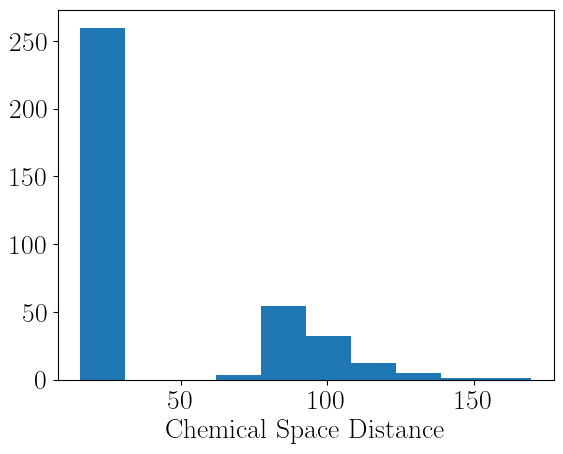

In [124]:
plt.hist(test_dist)
plt.xlabel("Chemical Space Distance")
plt.show()

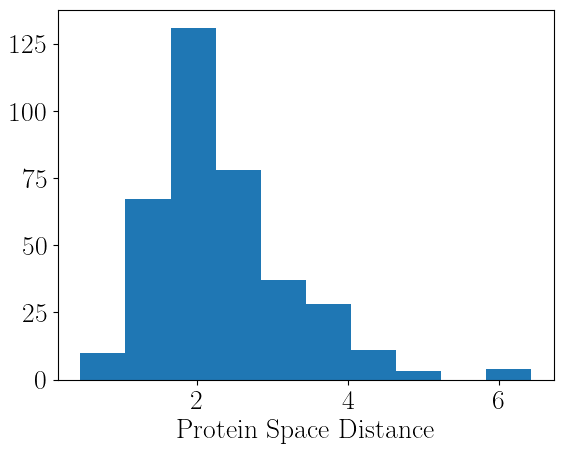

In [125]:
plt.hist(test_dist_protein)
plt.xlabel("Protein Space Distance")
plt.show()

In [126]:
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

In [127]:
test_dist = torch.nan_to_num(test_dist, nan=test_dist.nanmean())

In [128]:
distance_df = pd.DataFrame({"chemical_distance": test_dist, "assay_id": train_assays})
distance_df_protein = pd.DataFrame(
    {"protein_distance": test_dist_protein, "assay_id": train_assays_protein}
)

distance_df.set_index("assay_id", inplace=True)
distance_df_protein.set_index("assay_id", inplace=True)

In [129]:
weights = []
for ids in distance_df.index.to_list():
    weights.append(fsmol_internal_distance[ids])
distance_df["weights"] = weights
distance_df["weighted_chemical_distance"] = (1 - distance_df["weights"]) * distance_df[
    "chemical_distance"
]

In [130]:
distance_df["chemical_distance"] = normalize(distance_df["chemical_distance"])
distance_df["weighted_chemical_distance"] = normalize(distance_df["weighted_chemical_distance"])
distance_df_protein["protein_distance"] = normalize(distance_df_protein["protein_distance"])

In [131]:
dist_df = pd.merge(distance_df, distance_df_protein, left_index=True, right_index=True)

In [132]:
dist_df

,chemical_distance,weights,weighted_chemical_distance,protein_distance
assay_id,,,,
CHEMBL2219001,0.028311,0.410865,0.177278,0.671913
CHEMBL829401,0.540253,0.897500,0.149110,0.310976
CHEMBL2219213,0.011652,0.665592,0.078869,0.255313
CHEMBL2219025,0.024919,0.410355,0.172383,0.208929
CHEMBL2219108,0.007583,0.639807,0.082603,0.286846
...,...,...,...,...
CHEMBL1738482,0.406692,0.659295,0.421522,0.489806
CHEMBL2219303,0.026404,0.466298,0.156356,0.248812
CHEMBL2219247,0.007109,0.633925,0.083802,0.291731


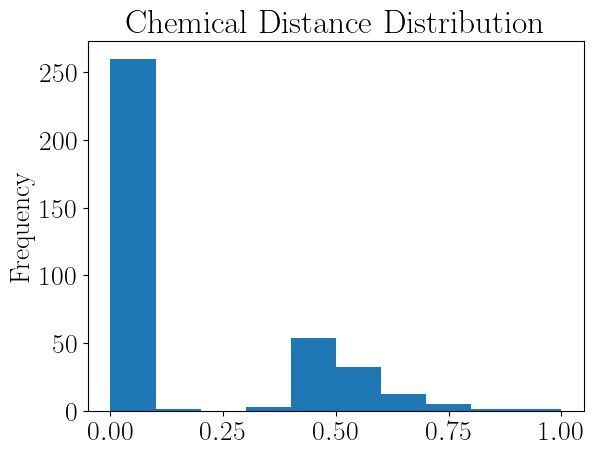

In [133]:
dist_df["chemical_distance"].plot(kind="hist", bins=10, title="Chemical Distance Distribution")
plt.show()

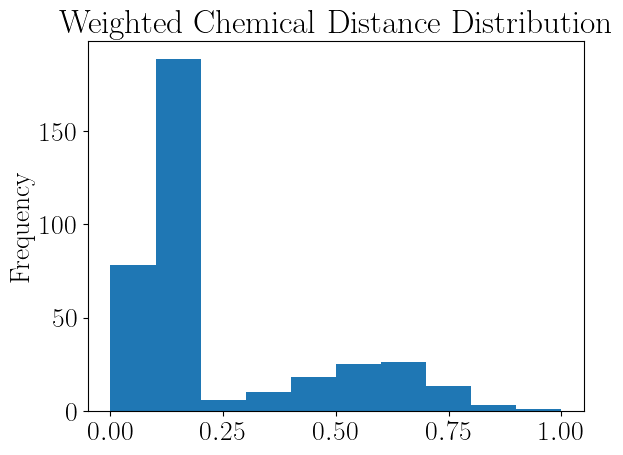

In [134]:
dist_df["weighted_chemical_distance"].plot(
    kind="hist", bins=10, title="Weighted Chemical Distance Distribution"
)
plt.show()

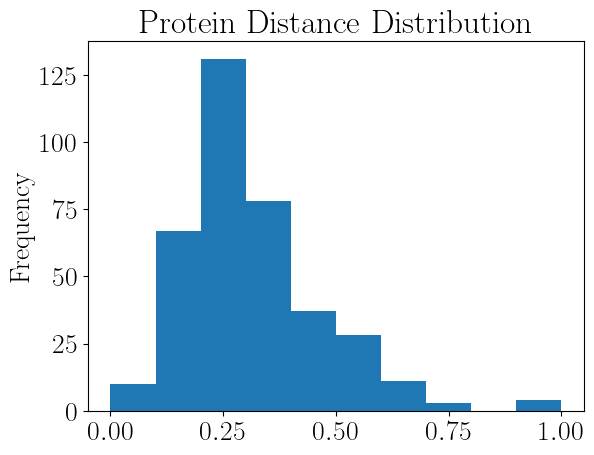

In [135]:
dist_df["protein_distance"].plot(kind="hist", bins=10, title="Protein Distance Distribution")
plt.show()

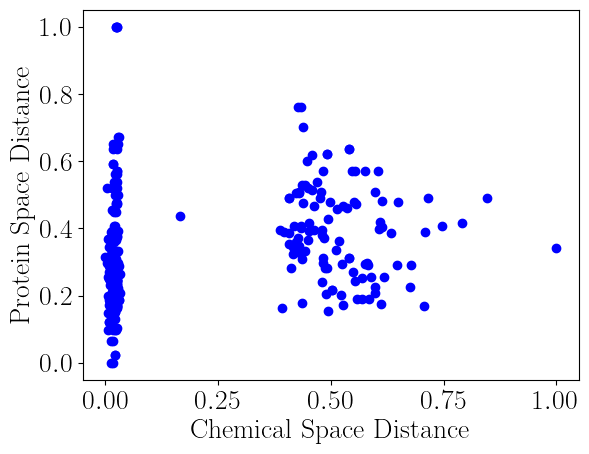

In [136]:
plt.scatter(dist_df["chemical_distance"], dist_df["protein_distance"], color="blue")
plt.xlabel("Chemical Space Distance")
plt.ylabel("Protein Space Distance")
plt.show()

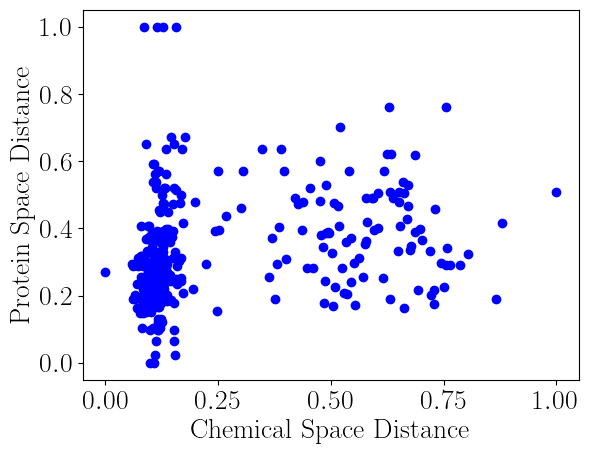

In [137]:
plt.scatter(dist_df["weighted_chemical_distance"], dist_df["protein_distance"], color="blue")
plt.xlabel("Chemical Space Distance")
plt.ylabel("Protein Space Distance")
plt.show()

In [138]:
print(dist_df["chemical_distance"].corr(dist_df["protein_distance"]))
print(dist_df["weighted_chemical_distance"].corr(dist_df["protein_distance"]))

0.2809620451235879
0.28221273524379664


In [139]:
# Extract performance measure
## Extract specific training fold


def evaluation_metric(train_fold=0, test_folds=5, chembl_id=chembl_id) -> pd.DataFrame:
    new_dict = {}

    for i in range(test_folds):
        fold_data = []
        fold_name = []
        for key, value in data[f"{chembl_id}_{i}"].items():
            if key.split("_")[1] == str(train_fold):
                fold_data.append(value)
                fold_name.append(key.split("_")[0])
        new_dict[f"fold_{i}"] = fold_data
        new_dict[f"name_{i}"] = fold_name

    eval_df = pd.DataFrame(new_dict)
    assert (
        eval_df["name_0"].values.all()
        == eval_df["name_1"].values.all()
        == eval_df["name_2"].values.all()
        == eval_df["name_3"].values.all()
        == eval_df["name_4"].values.all()
    )
    eval_df.set_index("name_0", inplace=True)
    eval_df.drop(["name_1", "name_2", "name_3", "name_4"], axis=1, inplace=True)

    return eval_df

In [140]:
eval_df = evaluation_metric(train_fold=0, test_folds=5, chembl_id=chembl_id)

In [141]:
eval_df_diff = (eval_df - last_valid_auc) / last_valid_auc * 100

In [142]:
eval_df_diff

,fold_0,fold_1,fold_2,fold_3,fold_4
name_0,,,,,
CHEMBL2219095,-15.740741,21.568627,-36.144578,70.707071,-7.913669
CHEMBL2219008,6.018519,25.490196,6.024096,64.646465,4.316547
CHEMBL2219153,-0.462963,34.313725,31.325301,60.606061,-10.071942
CHEMBL1676103,-20.833333,13.725490,33.734940,40.404040,-15.827338
CHEMBL2219068,0.925926,26.470588,6.024096,52.525253,-5.035971
...,...,...,...,...,...
CHEMBL3734165,-13.888889,22.549020,45.783133,32.323232,-2.877698
CHEMBL1614274,-18.055556,18.627451,-8.433735,28.282828,1.438849
CHEMBL2219199,-0.462963,26.470588,10.843373,53.535354,-0.719424


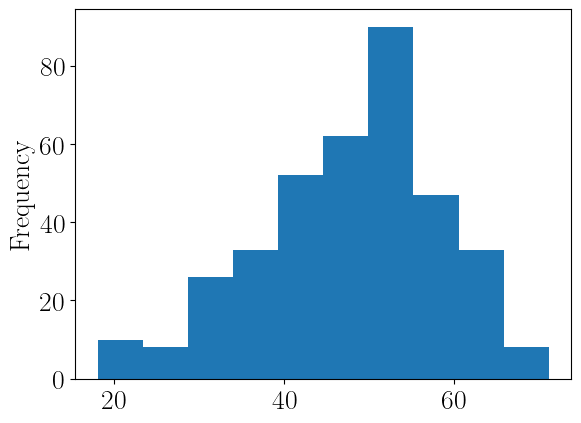

In [143]:
eval_df_diff.max(axis=1).plot(kind="hist")
plt.show()

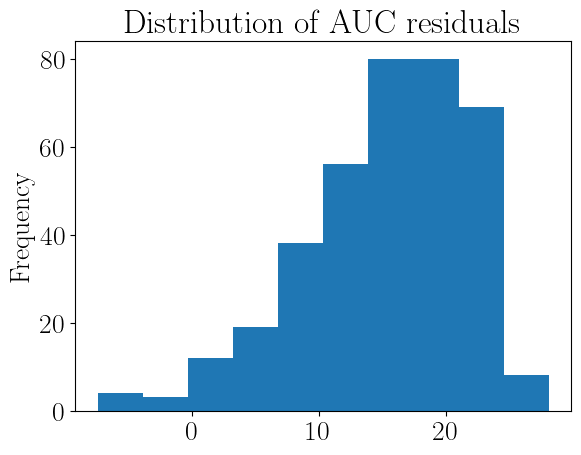

In [144]:
eval_df_diff.mean(axis=1).plot(kind="hist", bins=10, title="Distribution of AUC residuals")
plt.show()

In [145]:
mean_fold = eval_df_diff.mean(axis=1)
max_fold = eval_df_diff.max(axis=1)

eval_df_diff["mean_perf"] = mean_fold
eval_df_diff["max_perf"] = max_fold

In [146]:
final_df = pd.merge(eval_df_diff, dist_df, left_index=True, right_index=True)

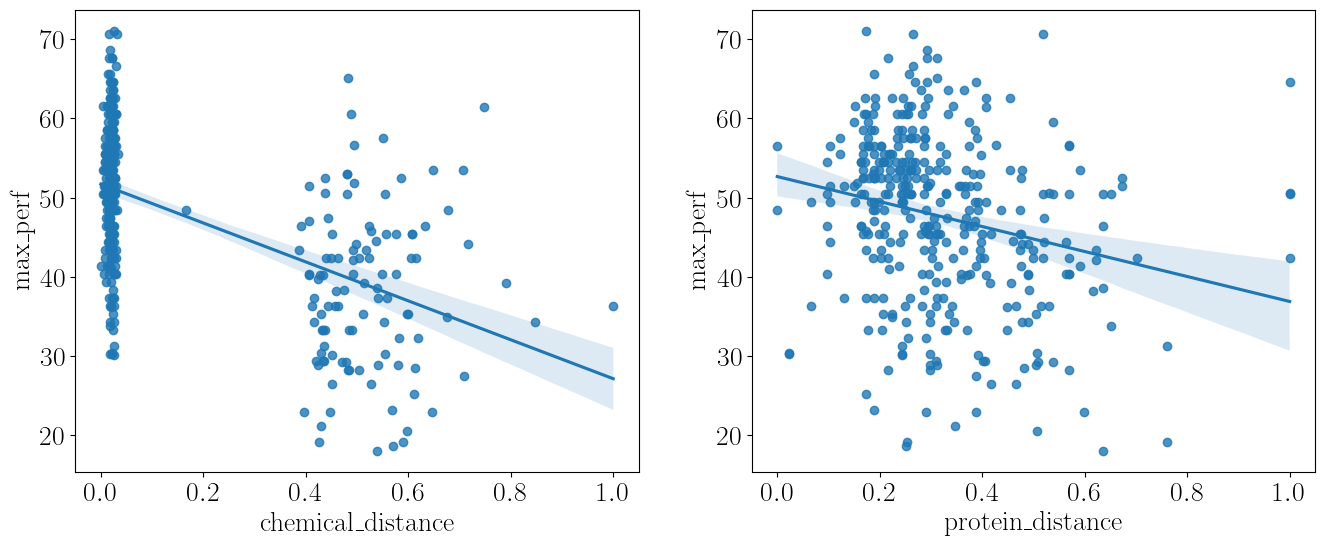

-0.5450201133806183
-0.22950408652625068


In [147]:
final_df["distance"] = final_df["chemical_distance"] + final_df["protein_distance"]
final_df["weighted_distance"] = (
    final_df["weighted_chemical_distance"] + final_df["protein_distance"]
)


fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(16, 6))
sns.regplot(x="chemical_distance", y="max_perf", data=final_df, ax=ax1)
sns.regplot(x="protein_distance", y="max_perf", data=final_df, ax=ax2)
plt.show()

print(final_df["max_perf"].corr(final_df["chemical_distance"]))
print(final_df["max_perf"].corr(final_df["protein_distance"]))

-0.5185798237625255
-0.5288006368911558


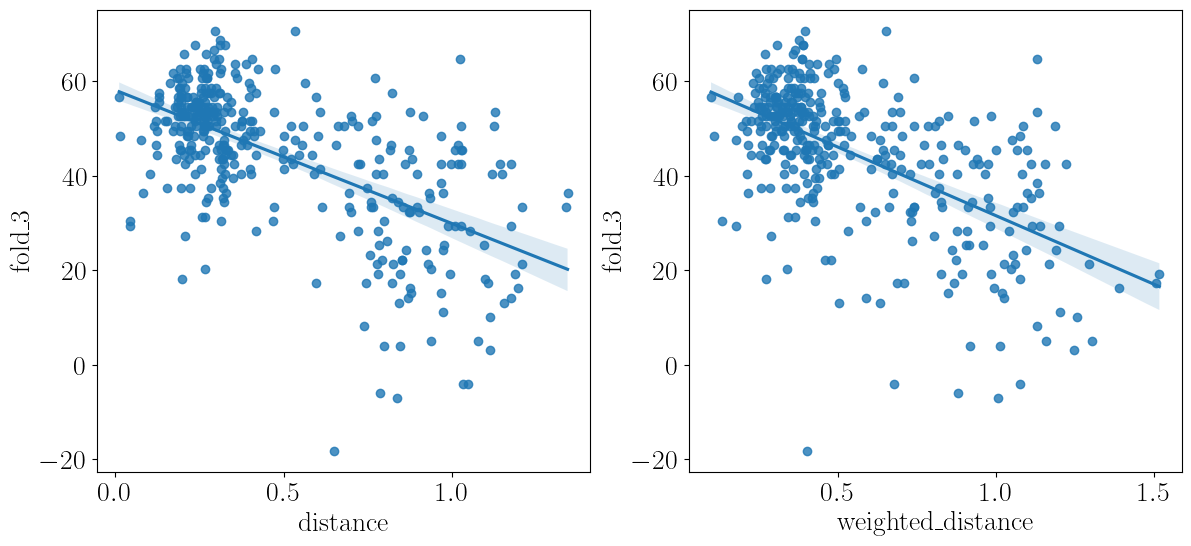

In [162]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(14, 6))
sns.regplot(x="distance", y="fold_3", data=final_df, ax=ax1)
sns.regplot(x="weighted_distance", y="fold_3", data=final_df, ax=ax2)

print(final_df["max_perf"].corr(final_df["distance"]))
print(final_df["max_perf"].corr(final_df["weighted_distance"]))

In [154]:
final_df.sort_values(by="distance", ascending=True).head(10)

,fold_0,fold_1,fold_2,fold_3,fold_4,mean_perf,max_perf,chemical_distance,weights,weighted_chemical_distance,protein_distance,distance,weighted_distance
CHEMBL2219053,-2.777778,40.196078,36.144578,56.565657,-16.546763,22.716355,56.565657,0.012949,0.600725,0.098911,0.000000,0.012949,0.098911
CHEMBL2219052,-13.425926,31.372549,14.457831,48.484848,-2.877698,15.602321,48.484848,0.016342,0.578666,0.108973,0.000000,0.016342,0.108973
CHEMBL2219055,-16.203704,3.921569,2.409639,30.303030,7.194245,5.524956,30.303030,0.020861,0.592365,0.109521,0.023912,0.044773,0.133432
CHEMBL2219054,-3.703704,30.392157,19.277108,29.292929,-7.913669,13.468964,30.392157,0.021607,0.452055,0.154344,0.023912,0.045519,0.178255
CHEMBL2219313,2.314815,8.823529,49.397590,47.474747,-0.719424,21.458252,49.397590,0.011843,0.553636,0.111413,0.065106,0.076949,0.176519
CHEMBL2219314,3.240741,22.549020,26.506024,36.363636,-8.633094,16.005265,36.363636,0.018080,0.444903,0.151631,0.065106,0.083186,0.216737
CHEMBL2219210,6.481481,23.529412,28.915663,40.404040,-12.949640,17.276191,40.404040,0.005628,0.511268,0.115976,0.097246,0.102874,0.213222
CHEMBL2219111,0.000000,44.117647,1.204819,50.505051,1.438849,19.453273,50.505051,0.017934,0.613929,0.099929,0.097246,0.115180,0.197175
CHEMBL2219209,-4.629630,26.470588,-1.204819,54.545455,0.000000,15.036319,54.545455,0.021095,0.453465,0.153192,0.097246,0.118341,0.250438
CHEMBL2219110,-31.944444,12.745098,-21.686747,46.464646,7.913669,2.698444,46.464646,0.024501,0.579308,0.117473,0.097246,0.121747,0.214719


In [155]:
final_df.sample(n=10)

,fold_0,fold_1,fold_2,fold_3,fold_4,mean_perf,max_perf,chemical_distance,weights,weighted_chemical_distance,protein_distance,distance,weighted_distance
CHEMBL2219112,0.925926,38.235294,8.433735,52.525253,-5.755396,18.872962,52.525253,0.021796,0.604949,0.106528,0.179045,0.200840,0.285573
CHEMBL897839,-12.037037,31.372549,2.409639,42.424242,-16.546763,9.524526,42.424242,0.614212,0.778201,0.384794,0.402825,1.017037,0.787619
CHEMBL2219096,1.851852,19.607843,18.072289,57.575758,-9.352518,17.551045,57.575758,0.022477,0.529044,0.131210,0.232863,0.255341,0.364073
CHEMBL3734165,-13.888889,22.549020,45.783133,32.323232,-2.877698,16.777760,45.783133,0.528100,0.641703,0.554360,0.173153,0.701253,0.727513
CHEMBL2219107,-3.240741,47.058824,8.433735,52.525253,-12.949640,18.365486,52.525253,0.015503,0.737419,0.060689,0.286846,0.302349,0.347534
CHEMBL2219199,-0.462963,26.470588,10.843373,53.535354,-0.719424,17.933386,53.535354,0.011760,0.485051,0.131143,0.261058,0.272818,0.392201
CHEMBL2219373,4.629630,13.725490,25.301205,49.494949,-4.316547,17.766945,49.494949,0.016872,0.490101,0.136284,0.384972,0.401844,0.521256
CHEMBL2218986,4.166667,34.313725,27.710843,46.464646,10.071942,24.545565,46.464646,0.009424,0.577194,0.102010,0.365347,0.374771,0.467357
CHEMBL2219015,4.166667,32.352941,8.433735,58.585859,2.158273,21.139495,58.585859,0.023774,0.643763,0.096108,0.167584,0.191358,0.263692
CHEMBL1614091,-35.648148,30.392157,-45.783133,50.505051,-10.791367,-2.265088,50.505051,0.481060,0.618973,0.545261,0.240917,0.721977,0.786178


In [160]:
final_df["distance"].corr(final_df["fold_4"])

-0.4332373633552039